In [280]:
import matplotlib.pyplot as plt
import itertools
import json
import numpy as np
from pylhe import read_lhe_with_attributes, read_num_events
import itertools
import json
import math
import vector

### Defining Functions

In [281]:
def extract_particle_data(lhe_file, particle_ids):
    """Extract data for specific particle IDs from the LHE file."""
    
    events = read_lhe_with_attributes(lhe_file)

    num_events = read_num_events(lhe_file)

    particle_data = []


    if not isinstance(particle_ids, list):
        particle_ids = [particle_ids] 


    for event_index, event in enumerate(itertools.islice(events, num_events)):
        for particle in event.particles:

            if particle.id in particle_ids:  
                particle_data.append({
                    'event': event_index,
                    'id': particle.id,
                    'px': particle.px,
                    'py': particle.py,
                    'pz': particle.pz,
                    'E': particle.e,
                    'status': particle.status
                })

    return particle_data

def extract_kinematic_data(particle_data):
    """Extract transverse momentum (pT), pseudorapidity (eta), and azimuthal angle (phi) for each particle."""
    kinematic_data = []


    for particle in particle_data:
        px, py, pz = particle['px'], particle['py'], particle['pz']


        pt = math.sqrt(px**2 + py**2)


        phi = math.atan2(py, px)


        theta = math.acos(pz / math.sqrt(px**2 + py**2 + pz**2))
        eta = -math.log(math.tan(theta / 2))


        kinematic_data.append({
            'pt': pt,
            'eta': eta,
            'phi': phi,
        })

    return kinematic_data


### Importing Data

In [333]:
def contruct_four_vector(data_set):

    four_vector = vector.array({"E": [data["E"] for data in data_set], 
                                "px": [data["px"] for data in data_set], 
                                "py": [data["py"] for data in data_set], 
                                "pz": [data["pz"] for data in data_set]})
    
    return four_vector

def construct_three_momentum(four_vector):

    three_momentum = vector.array({"px": four_vector.px, 
                                   "py": four_vector.py, 
                                   "pz": four_vector.pz})
    return three_momentum

def angle_between_vector_axis(axis, four_vector):

    three_vector = construct_three_momentum(four_vector)
    rotation_axes = three_vector.cross(axis).unit()
    cos_theta = three_vector.dot(axis) / (abs(three_vector) * abs(axis))
    rotation_angles = np.arccos(cos_theta)

    return rotation_angles, rotation_axes

def invariant_mass_check(vector_1, vector_2):
    # Check if the mass values are close for all elements
    mass_diff = np.isclose(vector_1.mass, vector_2.mass, atol=1e-5)
    
    if np.all(mass_diff):
        print("Invariant mass check passed.")
    else:
        changed_indices = np.where(~mass_diff)[0]  # Find indices where mass has changed
        for idx in changed_indices:
            print(f"Warning: Invariant mass changed at index {idx}! Initial: {vector_1.mass[idx]}, Final: {vector_2.mass[idx]}")
    
    return

def rotate_and_boost(affected_vector, reference_vector, axis):
    reference_three_vector = construct_three_momentum(reference_vector)
    rotation_axes = reference_three_vector.cross(axis).unit()
    cos_theta = reference_three_vector.dot(axis) / (abs(reference_three_vector) * abs(axis))

    rotation_angles = np.arccos(cos_theta)

    transverse_momenta = np.sqrt(affected_vector.px**2 + affected_vector.py**2)
    non_zero_mask = transverse_momenta > 0
    rotated_reference_three_vector = reference_three_vector
    rotated_reference_three_vector[non_zero_mask] = reference_three_vector[non_zero_mask].rotate_axis(rotation_axes, rotation_angles)

    rotated_reference_four_vector = vector.array({"E": reference_vector.E, "px": rotated_reference_three_vector.px, "py": rotated_reference_three_vector.py, "pz": rotated_reference_three_vector.pz})
    invariant_mass_check(reference_vector, rotated_reference_four_vector)

    rotated_affected_vector = affected_vector
    rotated_affected_vector[non_zero_mask] = affected_vector[non_zero_mask].rotate_axis(rotation_axes, rotation_angles)
    invariant_mass_check(affected_vector, rotated_affected_vector)

    boost_vector = rotated_reference_four_vector.to_beta3()
    rotated_boosted_affected_vector = rotated_affected_vector.boost(-boost_vector)
    invariant_mass_check(rotated_affected_vector, rotated_boosted_affected_vector)

    return rotated_boosted_affected_vector

def rotate_and_boost2(affected_vector, reference_vector, axis):
    reference_three_vector = construct_three_momentum(reference_vector)
    rotation_axes = reference_three_vector.cross(axis).unit()
    cos_theta = reference_three_vector.dot(axis) / (abs(reference_three_vector) * abs(axis))
    cos_theta = np.clip(reference_three_vector.dot(axis) / (abs(reference_three_vector) * abs(axis)), -1, 1)

    rotation_angles = np.arccos(cos_theta)

    rotated_reference_three_vector = reference_three_vector.rotate_axis(rotation_axes, rotation_angles)
    rotated_reference_four_vector = vector.array({"E": reference_vector.E, "px": rotated_reference_three_vector.px, "py": rotated_reference_three_vector.py, "pz": rotated_reference_three_vector.pz})
    rotated_affected_vector = affected_vector.rotate_axis(rotation_axes, rotation_angles)
    
    boost_vector = rotated_reference_four_vector.pz/rotated_reference_four_vector.E
    rotated_boosted_affected_vector = rotated_affected_vector.boostZ(-boost_vector)
    return rotated_boosted_affected_vector

def find_decay_angle(four_vector):
    cos_theta =  four_vector.pz / np.sqrt(four_vector.px**2 + four_vector.py**2 + four_vector.pz**2)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    theta = np.arccos(cos_theta)

    return theta

def plot_histogram(data, title, file_name):
    # Convert angle data to cos(theta) if data contains angles in degrees
    cos_theta_data = np.cos(data)  # Assuming 'data' is in degrees

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Two subplots, stacked vertically

    # First subplot for angle
    ax1.hist(data, bins=50, alpha=0.7, color='blue')
    ax1.set_xlabel('Angle (Degrees)')
    ax1.set_ylabel('Number of Muons')
    ax1.set_title(f"{title} - Angles")
    ax1.grid(axis='y', alpha=0.75)
    ax1.text(0.95, 0.95, f'Number of Muons: {len(data)}', 
             ha='right', va='top', fontsize=12, transform=ax1.transAxes)

    # Second subplot for cos(theta)
    ax2.hist(cos_theta_data, bins=50, alpha=0.7, color='orange')
    ax2.set_xlabel('cos(θ)')
    ax2.set_ylabel('Number of Muons')
    ax2.set_title(f"{title} - cos(θ)")
    ax2.grid(axis='y', alpha=0.75)
    ax2.text(0.95, 0.95, f'Number of Events: {len(data)}', 
             ha='right', va='top', fontsize=12, transform=ax2.transAxes)

    plt.tight_layout(rect=[0, 0, 0.96, 0.96])  # Adjust layout to make room for the overall title
    
    # Correct the file path using forward slashes or raw string
    save_path = r"C:\Users\gabri\OneDrive\Documents\University\Mphys\TriBoson\Week4\Plots\Polarity" + f"\\{file_name}.png"
    plt.savefig(save_path, dpi=300)
    plt.show()

    return


In [283]:
lhe_file = r"C:\Users\gabri\OneDrive\Documents\University\Mphys\TriBoson\Week4\unweighted_events.lhe"

z_data = extract_particle_data(lhe_file, particle_ids=[23])
muon_data = extract_particle_data(lhe_file, particle_ids=[13])
anti_muon_data = extract_particle_data(lhe_file, particle_ids=[-13])

w_data = extract_particle_data(lhe_file, particle_ids=[24])
electron_neutrino_data = extract_particle_data(lhe_file, particle_ids=[12])
anti_electron_data = extract_particle_data(lhe_file, particle_ids=[-11])

w_anti_data = extract_particle_data(lhe_file, particle_ids=[-24])
electron_data = extract_particle_data(lhe_file, particle_ids=[11])
anti_electron_neutrino_data = extract_particle_data(lhe_file, particle_ids=[-12])

In [334]:
z_four_momentum = contruct_four_vector(z_data)
muon_four_momentum = contruct_four_vector(muon_data)
anti_muon_four_momentum = contruct_four_vector(anti_muon_data)

w_four_momentum = contruct_four_vector(w_data)
electron_neutrino_four_momentum = contruct_four_vector(electron_neutrino_data)
anti_electron_four_momentum = contruct_four_vector(anti_electron_data)

w_anti_four_momentum = contruct_four_vector(w_anti_data)
electron_four_momentum = contruct_four_vector(electron_data)
anti_electron_neutrino_four_momentum = contruct_four_vector(anti_electron_neutrino_data)

com_four_momentum = z_four_momentum + w_four_momentum + w_anti_four_momentum

In [335]:
z_axis = vector.obj(x=0, y=0, z=1)

z_four_momentum_com = rotate_and_boost(z_four_momentum, com_four_momentum, z_axis)
muon_four_momentum_com = rotate_and_boost(muon_four_momentum, com_four_momentum, z_axis)
anti_muon_four_momentum_com = rotate_and_boost(anti_muon_four_momentum, com_four_momentum, z_axis)


w_four_momentum_com = rotate_and_boost(w_four_momentum, com_four_momentum, z_axis)
electron_neutrino_four_momentum_com = rotate_and_boost(electron_neutrino_four_momentum, com_four_momentum, z_axis)
anti_electron_four_momentum_com = rotate_and_boost(anti_electron_four_momentum, com_four_momentum, z_axis)

w_anti_four_momentum_com = rotate_and_boost(w_anti_four_momentum, com_four_momentum, z_axis)
electron_four_momentum_com = rotate_and_boost(electron_four_momentum, com_four_momentum, z_axis)
anti_electron_neutrino_four_momentum_com = rotate_and_boost(anti_electron_neutrino_four_momentum, com_four_momentum, z_axis)


Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.


In [336]:
muon_four_momentum_z_rest = rotate_and_boost(muon_four_momentum_com, z_four_momentum_com, z_axis)
muon_angles= find_decay_angle(muon_four_momentum_z_rest)

anti_muon_four_momentum_z_rest = rotate_and_boost(anti_muon_four_momentum_com, z_four_momentum_com, z_axis)
anti_muon_angles = find_decay_angle(anti_muon_four_momentum_z_rest)

Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.


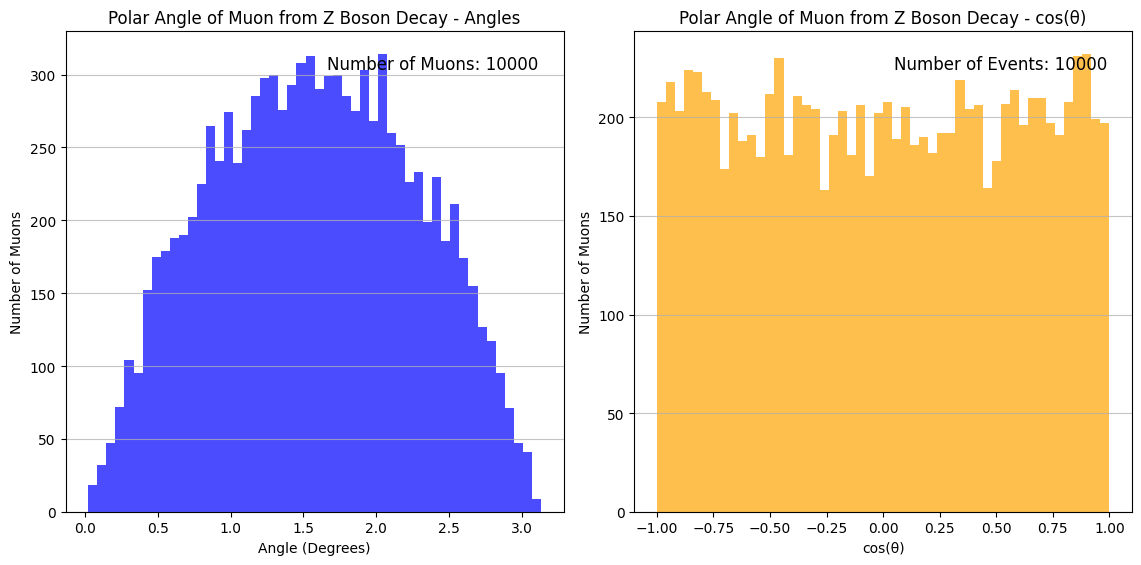

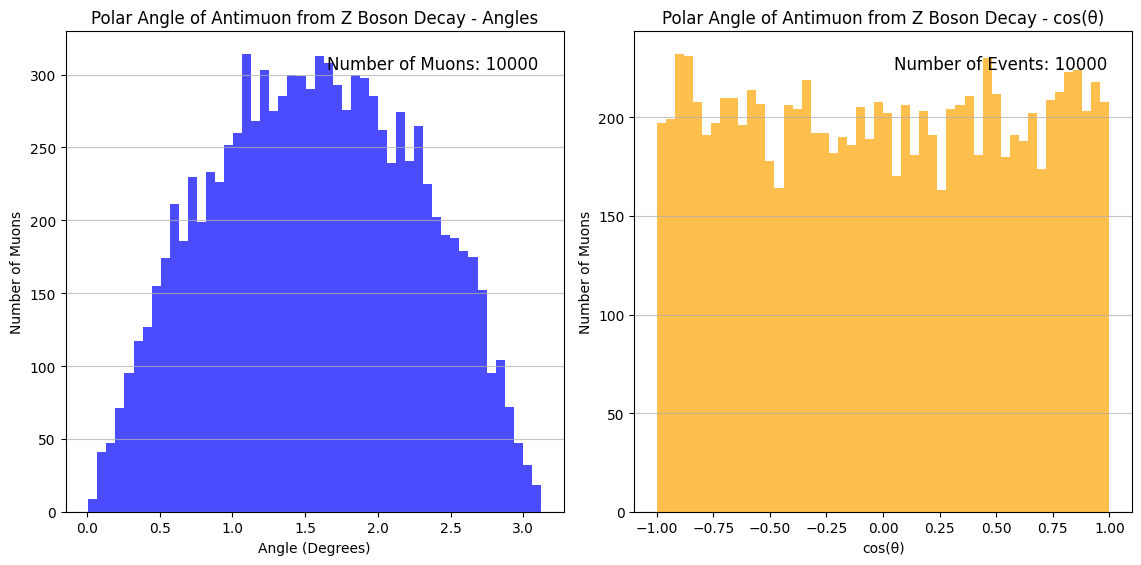

In [346]:
plot_histogram(muon_angles, "Polar Angle of Muon from Z Boson Decay", "Polarity ZBoson (muon)")
plot_histogram(anti_muon_angles, "Polar Angle of Antimuon from Z Boson Decay", "Polarity ZBoson (antimuon)")


In [338]:
electron_neutrino_four_momentum_w_rest = rotate_and_boost2(electron_neutrino_four_momentum_com, w_four_momentum_com, z_axis)
electron_neutrino_angles= find_decay_angle(electron_neutrino_four_momentum_w_rest)

anti_electron_four_momentum_z_rest = rotate_and_boost2(anti_electron_four_momentum_com, w_four_momentum_com, z_axis)
anti_electron_angles = find_decay_angle(anti_electron_four_momentum_z_rest)

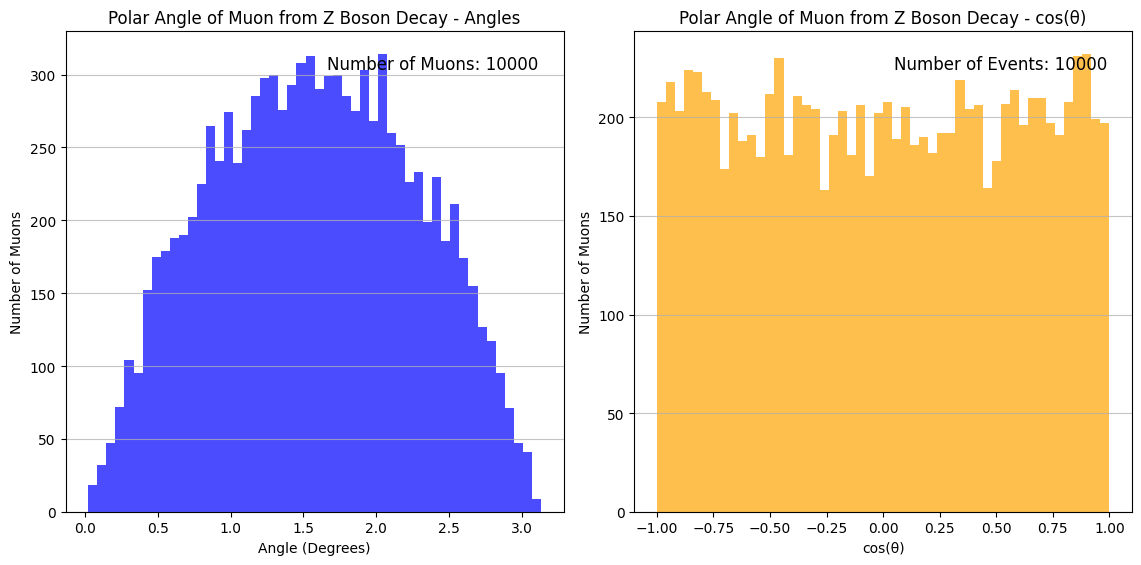

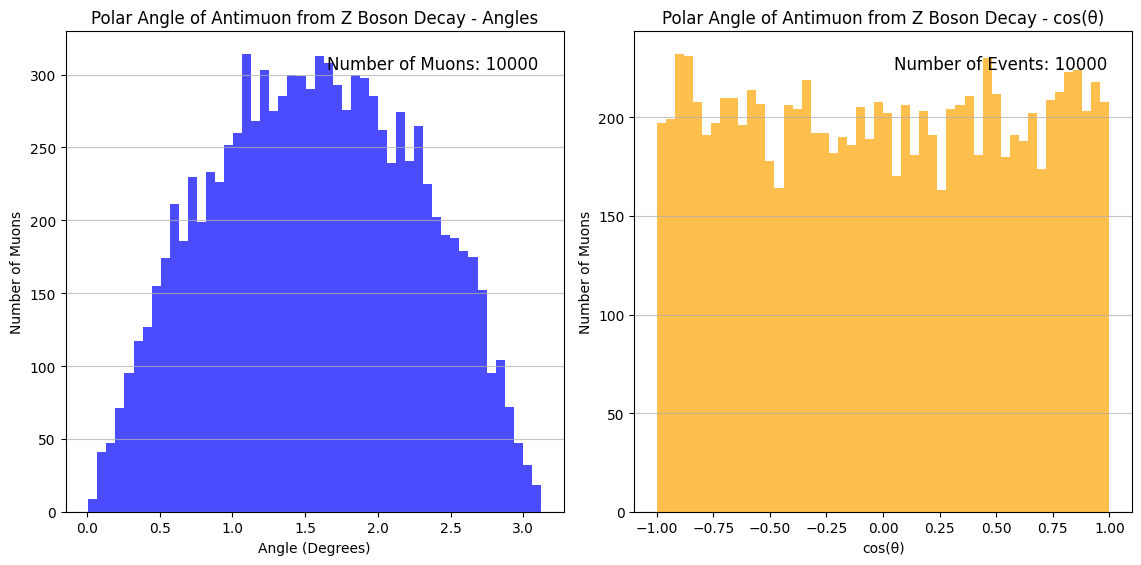

In [339]:
plot_histogram(muon_angles, "Polar Angle of Muon from Z Boson Decay", "Polarity WBoson (muon)")
plot_histogram(anti_muon_angles, "Polar Angle of Antimuon from Z Boson Decay", "trial")


In [340]:
electron_neutrino_four_momentum_w_rest = rotate_and_boost(electron_neutrino_four_momentum_com, w_four_momentum_com, z_axis)
electron_neutrino_angles= find_decay_angle(electron_neutrino_four_momentum_w_rest)

anti_electron_four_momentum_z_rest = rotate_and_boost(anti_electron_four_momentum_com, w_four_momentum_com, z_axis)
anti_electron_angles = find_decay_angle(anti_electron_four_momentum_z_rest)

Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.


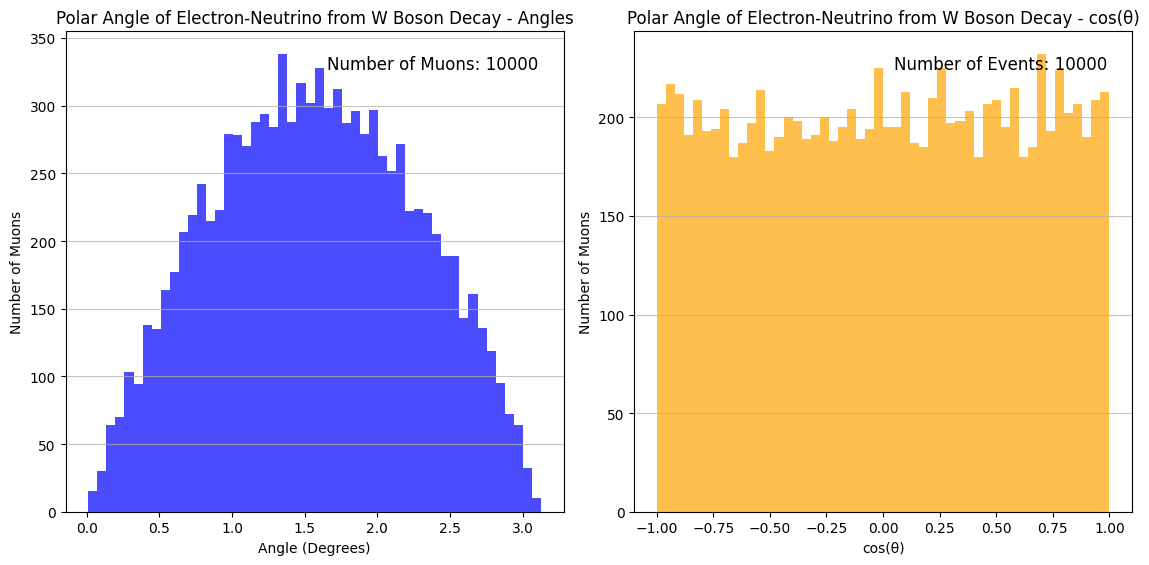

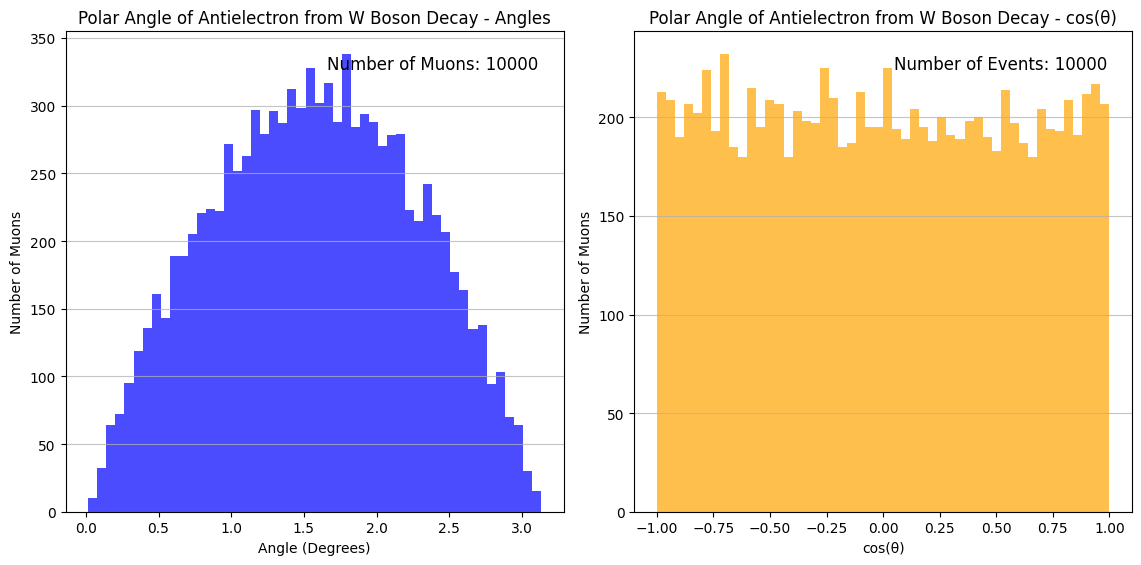

In [344]:
plot_histogram(electron_neutrino_angles, "Polar Angle of Electron-Neutrino from W Boson Decay", "Polarity WBoson (Electron Neutrino)")
plot_histogram(anti_electron_angles, "Polar Angle of Antielectron from W Boson Decay", "Polarity WBoson (Antielectron)")


In [342]:
anti_electron_neutrino_four_momentum_w_rest = rotate_and_boost(anti_electron_neutrino_four_momentum_com, w_anti_four_momentum_com, z_axis)
anti_electron_neutrino_angles= find_decay_angle(anti_electron_neutrino_four_momentum_w_rest)

electron_four_momentum_z_rest = rotate_and_boost(electron_four_momentum_com, w_anti_four_momentum_com, z_axis)
electron_angles = find_decay_angle(electron_four_momentum_z_rest)

Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.
Invariant mass check passed.


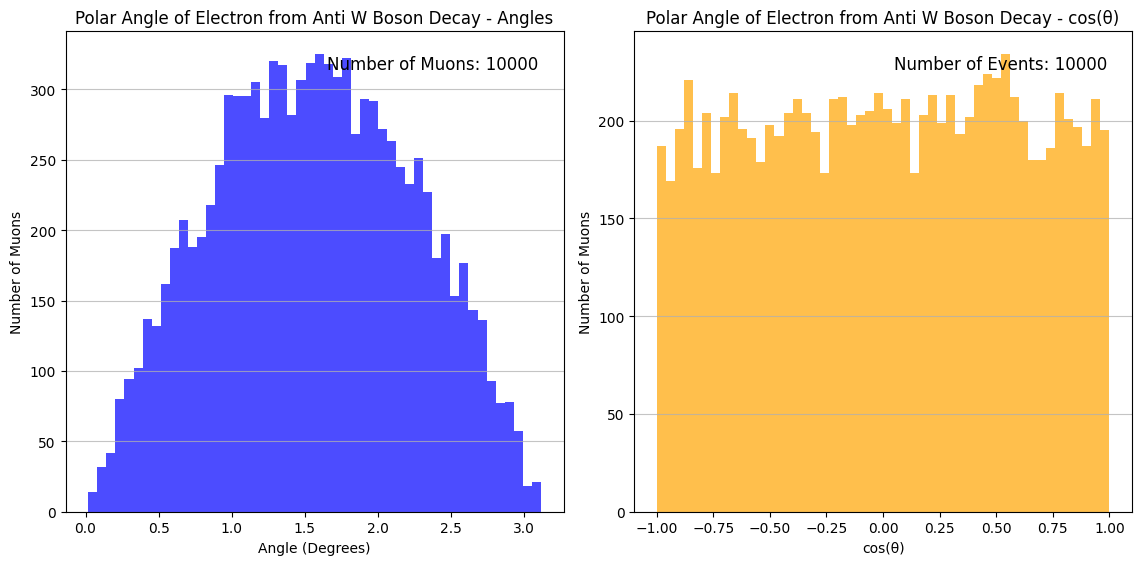

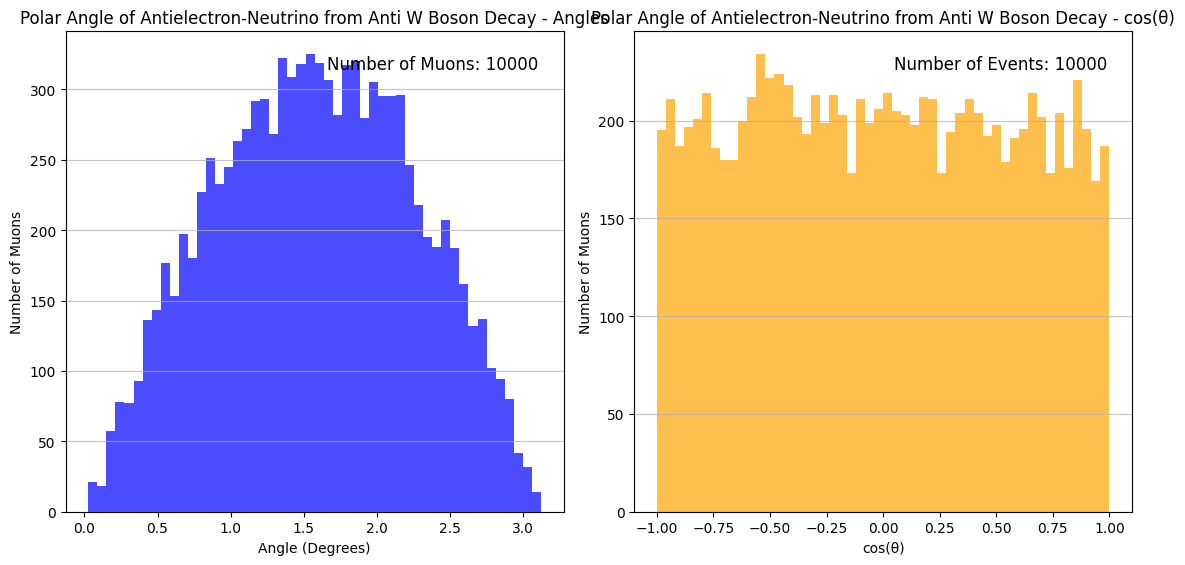

In [345]:
plot_histogram(electron_angles, "Polar Angle of Electron from Anti W Boson Decay", "Polarity Anti WBoson (Electron)")
plot_histogram(anti_electron_neutrino_angles, "Polar Angle of Antielectron-Neutrino from Anti W Boson Decay", "Polarity Anti WBoson (Anti Electron-Neutrino)")
